## General Adversarial Network

#### Build an simple GAN with pytorch

In [44]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import Variable

In [45]:
# data parameters
data_mean = 4
data_stddev = 1.25

In [46]:
# ### Uncomment only one of these to define what data is actually sent to the Discriminator
# (name, preprocess, d_input_func) = ("Raw data", lambda data: data, lambda x: x)
#(name, preprocess, d_input_func) = ("Data and variances", lambda data: decorate_with_diffs(data, 2.0), lambda x: x * 2)
#(name, preprocess, d_input_func) = ("Data and diffs", lambda data: decorate_with_diffs(data, 1.0), lambda x: x * 2)
(name, preprocess, d_input_func) = ("Only 4 moments", lambda data: get_moments(data), lambda x: 4)

print("Using data [%s]" % (name))

Using data [Only 4 moments]


In [47]:
def get_moments(d):
    # Return the first 4 moments of the data provided
    mean = torch.mean(d)
    diffs = d - mean
    var = torch.mean(torch.pow(diffs, 2.0))
    std = torch.pow(var, 0.5)
    zscores = diffs / std
    skews = torch.mean(torch.pow(zscores, 3.0))
    kurtoses = torch.mean(torch.pow(zscores, 4.0)) - 3.0  # excess kurtosis, should be 0 for Gaussian
    final = torch.cat((mean.reshape(1,), std.reshape(1,), skews.reshape(1,), kurtoses.reshape(1,)))
    return final

In [48]:
# ##### DATA: Target data and generator input data

In [49]:
def get_distribution_sampler(mu, sigma):
    return lambda n: torch.Tensor(np.random.normal(mu, sigma, (1, n)))

In [50]:
def get_generator_input_sampler():
    return lambda m, n: torch.rand(m, n)

In [51]:
# ##### MODELS: Generator model and discriminator model

In [52]:
class Generator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Generator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.map1(x)
        x = self.f(x)
        x = self.map2(x)
        x = self.f(x)
        x = self.map3(x)
        return x

In [53]:
class Discriminator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, f):
        super(Discriminator, self).__init__()
        self.map1 = nn.Linear(input_size, hidden_size)
        self.map2 = nn.Linear(hidden_size, hidden_size)
        self.map3 = nn.Linear(hidden_size, output_size)
        self.f = f

    def forward(self, x):
        x = self.f(self.map1(x))
        x = self.f(self.map2(x))
        return self.f(self.map3(x))

In [54]:
# helper functions
def extract(v):
    return v.data.storage().tolist()

def stats(d):
    return [np.mean(d), np.std(d)]

In [113]:
fake_data_total_mean = []
fake_data_total_std = []

def train():
    # Model parameters
    g_input_size = 1      # Random noise dimension coming into generator, per output vector
    g_hidden_size = 5     # Generator complexity
    g_output_size = 1     # Size of generated output vector
    d_input_size = 500    # Minibatch size - cardinality of distributions
    d_hidden_size = 10    # Discriminator complexity
    d_output_size = 1     # Single dimension for 'real' vs. 'fake' classification
    minibatch_size = d_input_size

    d_learning_rate = 1e-3
    g_learning_rate = 1e-3
    sgd_momentum = 0.9

    num_epochs = 5000
    print_interval = 100
    d_steps = 20
    g_steps = 20

    dfe, dre, ge = 0, 0, 0
    d_real_data, d_fake_data, g_fake_data = None, None, None

    discriminator_activation_function = torch.sigmoid
    generator_activation_function = torch.tanh

    d_sampler = get_distribution_sampler(data_mean, data_stddev)
    gi_sampler = get_generator_input_sampler()
    G = Generator(input_size=g_input_size,
                  hidden_size=g_hidden_size,
                  output_size=g_output_size,
                  f=generator_activation_function)
    D = Discriminator(input_size=d_input_func(d_input_size),
                      hidden_size=d_hidden_size,
                      output_size=d_output_size,
                      f=discriminator_activation_function)
    criterion = nn.BCELoss()  # Binary cross entropy: http://pytorch.org/docs/nn.html#bceloss
    d_optimizer = optim.SGD(D.parameters(), lr=d_learning_rate, momentum=sgd_momentum)
    g_optimizer = optim.SGD(G.parameters(), lr=g_learning_rate, momentum=sgd_momentum)

    for epoch in range(num_epochs):
        for d_index in range(d_steps):
            # 1. Train D on real+fake
            D.zero_grad()

            #  1A: Train D on real
            d_real_data = Variable(d_sampler(d_input_size))
            d_real_decision = D(preprocess(d_real_data))
            d_real_error = criterion(d_real_decision, Variable(torch.ones([1,1])))  # ones = true
            d_real_error.backward() # compute/store gradients, but don't change params

            #  1B: Train D on fake
            d_gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            d_fake_data = G(d_gen_input).detach()  # detach to avoid training G on these labels
            d_fake_decision = D(preprocess(d_fake_data.t()))
            d_fake_error = criterion(d_fake_decision, Variable(torch.zeros([1,1])))  # zeros = fake
            d_fake_error.backward()
            d_optimizer.step()     # Only optimizes D's parameters; changes based on stored gradients from backward()

            dre, dfe = extract(d_real_error)[0], extract(d_fake_error)[0]

        for g_index in range(g_steps):
            # 2. Train G on D's response (but DO NOT train D on these labels)
            G.zero_grad()

            gen_input = Variable(gi_sampler(minibatch_size, g_input_size))
            g_fake_data = G(gen_input)
            dg_fake_decision = D(preprocess(g_fake_data.t()))
            g_error = criterion(dg_fake_decision, Variable(torch.ones([1,1])))  # Train G to pretend it's genuine

            g_error.backward()
            g_optimizer.step()  # Only optimizes G's parameters
            ge = extract(g_error)[0]

        if epoch % print_interval == 0:
            print("Epoch %s: D (%s real_err, %s fake_err) G (%s err); Real Dist (%s),  Fake Dist (%s) " %
                  (epoch, dre, dfe, ge, stats(extract(d_real_data)), stats(extract(d_fake_data))))
        
        fake_data_total_mean.append(stats(extract(d_fake_data))[0])
        fake_data_total_std.append(stats(extract(d_fake_data))[1])
        
    print("Plotting the generated distribution...")
    values = extract(g_fake_data)
    print(" Values: %s" % (str(values)))
    plt.hist(values, bins=50)
    plt.xlabel('Value')
    plt.ylabel('Count')
    plt.title('Histogram of Generated Distribution')
    plt.grid(True)
    plt.show()

Epoch 0: D (0.5858193635940552 real_err, 0.7971922755241394 fake_err) G (0.6004626154899597 err); Real Dist ([3.9686099824905394, 1.209864749304214]),  Fake Dist ([-0.7445635305643081, 0.003956508975362385]) 
Epoch 100: D (0.5517906546592712 real_err, 0.524402916431427 fake_err) G (0.9083622097969055 err); Real Dist ([3.9228567470610143, 1.2740115515198676]),  Fake Dist ([5.752979722976685, 0.0052915144481293745]) 
Epoch 200: D (0.6450185179710388 real_err, 0.746254026889801 fake_err) G (0.5307475924491882 err); Real Dist ([3.912894382506609, 1.2698072555519058]),  Fake Dist ([2.767543992996216, 1.7855853186608992]) 
Epoch 300: D (0.6329550743103027 real_err, 0.5767101645469666 fake_err) G (0.8112815022468567 err); Real Dist ([3.9683078723549845, 1.2827072737620786]),  Fake Dist ([5.820302245140076, 2.185725460388917]) 
Epoch 400: D (0.6961269974708557 real_err, 0.6702907085418701 fake_err) G (0.6936312913894653 err); Real Dist ([4.031248468101024, 1.3002820305237568]),  Fake Dist ([5.

Epoch 4000: D (0.6935973763465881 real_err, 0.6935539841651917 fake_err) G (0.6925705075263977 err); Real Dist ([3.970014814853668, 1.2676427370176242]),  Fake Dist ([3.929710750579834, 1.293044860002429]) 
Epoch 4100: D (0.6934470534324646 real_err, 0.6932559013366699 fake_err) G (0.692696213722229 err); Real Dist ([3.9280169551074504, 1.346037531881493]),  Fake Dist ([4.046282660484314, 1.2228069907068826]) 
Epoch 4200: D (0.6943747997283936 real_err, 0.6934741139411926 fake_err) G (0.6929668188095093 err); Real Dist ([3.971121159017086, 1.2995246996631422]),  Fake Dist ([3.94288671541214, 1.2432549353247166]) 
Epoch 4300: D (0.6932543516159058 real_err, 0.6935577988624573 fake_err) G (0.69251948595047 err); Real Dist ([4.076414698243141, 1.2635503219642452]),  Fake Dist ([3.9696536169052123, 1.2269810327873891]) 
Epoch 4400: D (0.6943914294242859 real_err, 0.6936326026916504 fake_err) G (0.6926292181015015 err); Real Dist ([3.9727790869772432, 1.2250777733190559]),  Fake Dist ([4.04

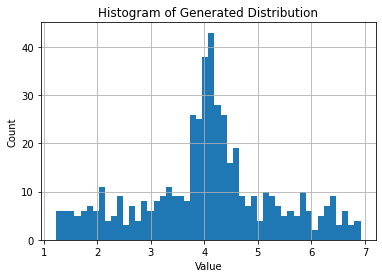

In [114]:
train()

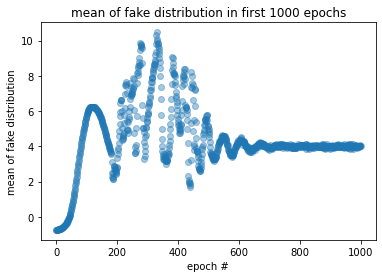

In [130]:
plt.scatter(range(0, len(fake_data_total_mean))[:1000], fake_data_total_mean[:1000], alpha=0.4)
plt.title('mean of fake distribution in first 1000 epochs')
plt.xlabel('epoch #')
plt.ylabel('mean of fake distribution')
plt.plot();

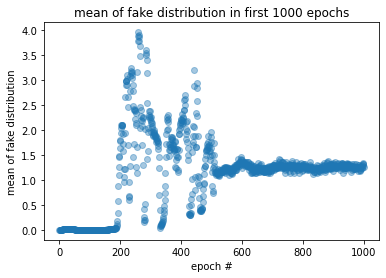

In [131]:
plt.scatter(range(0, len(fake_data_total_std))[:1000], fake_data_total_std[:1000], alpha=0.4)
plt.title('mean of fake distribution in first 1000 epochs')
plt.xlabel('epoch #')
plt.ylabel('mean of fake distribution')
plt.plot();